# Исходные данные

Дан набор данных с разметкой о токсичности правок.

 - text - текст комментария,
 - toxic - целевой признак.

# Задача

Интернет-магазин запускает сервис, в котором пользователи могут редактировать и дополнять описания товаров. Нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

 - Обучить модель классифицировать комментарии на позитивные и негативные. 
 - Метрика качества F1 - не меньше 0.75

 - Recall показывает долю истинно положительных ответов модели среди всех *реально* положительных объектов - то есть показывает способность обнаруживать данный класс вообще <данная метрика была бы актуальна, если бы нам надо было найти максимальное количество токсичных комментариев>; 
 - Presicion же показывает долю истинно положительных ответов модели среди всех *предсказанных* положительных объектов - то есть показывает способность отличать этот класс от других;    
 - F1 является гармоническим средним между этими метриками и используются при важности обеих метрик  

# Загрузка библиотек

In [1]:
# подгрузка библиотек 

%pip install spacy
!python -m spacy download en_core_web_sm
%pip install pandas jupyter pandarallel requests tqdm
%pip install wordcloud
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
# импорт библиотек
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import requests
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import random
random.seed(42)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import spacy
from wordcloud import WordCloud
from tqdm import tqdm, notebook
tqdm.pandas()

In [3]:
# инициируем модель для лемматизации текста

nlp = spacy.load('en_core_web_sm')

In [4]:
# создадим список стоп-слов

nltk.download('stopwords') 
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OLGAIARO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Обзор данных

In [5]:
# открытие файла

try:
    data = pd.read_csv('toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

In [6]:
# обзор

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [7]:
# выделим 5 слуачйных строк для обзора

data.sample(n=5) 

,text,toxic
18242,REDIRECT User talk:The Sports Diatribe/NCAA-AL...,0
128548,"""\nSubsequent entities\nI have changed the suc...",0
109267,"""\n\nWell that got ugly real quick. Sorry I co...",0
23267,Articles that rely on primary sources should o...,0
121160,] // 06 // [http://www.webcitation.org/5emm355...,0


In [8]:
# оценим состав текстов

print(data['text'][0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [9]:
# оценим баланс классов

print('Токсичные тексты -', round(data.loc[data['toxic']==1].shape[0]*100/data.shape[0]), '% от текста')

Токсичные тексты - 10 % от текста


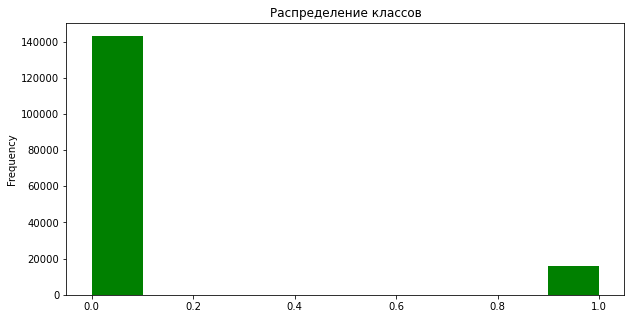

In [10]:
data['toxic'].plot(title='Распределение классов',
                   kind='hist',
                   color='green',
                   figsize=(10,5)
                  )

plt.show()

<div class="alert alert-warning">

**Вывод по обзору данных**

 - Закодировать данные в Юникод
 - Токенизировать и лемматизировать тексты
 - Очистить данные от стоп-слов (а также ненужных чисел, символов, ссылок и проч.)


 - При обучении необходимо учитывать дисбаланс классов

# Предобработка

In [11]:
# оценим наличие полных дубликатов в датасете

data.duplicated().sum()

0

In [12]:
# оценим наличие пропусков

data.isnull().sum()

text     0
toxic    0
dtype: int64

## Предобработка текста 

Напишем функцию для подготовки текстовых данных к обучению

Функция будет:
 - токенизировать текст корпуса
 - лемматизировать текст 
 - приведет каждое слово к нижнему регистру
 - очистит текст от стоп-слов
 - очистит данные от другх лишних символов
 - вернет очищенный и подготовленный текст формата строки

In [32]:
def clean(text):

    text = nlp(text)
        # лемматиризуем каждый текст с использованием POS (определения части речи) и перезаписываем его в исходный список
    text = ' '.join([word.lemma_ for word in text])
        # собираем разрозненные буквы снова в слова
    text = text.split(' ')
        
        # приводим все слова текста к нижнему регистру
    text = [str(word).lower() for word in text]
        
        # очищаем текст от стоп-слов 
    text = [word for word in text if word not in stopwords]
        
        # очищаем данные 
    text = re.sub(r'[^a-z]', ' ', str(text))
        # убираем полученные лишние пробелы (от удаления символов выше)
    text = text.split()
    
    return str(text)

In [33]:
# преобразуем корпус

X = data['text'].progress_apply(lambda x: clean(x))

100%|██████████████████████████████████████████████████████████████████████████| 159292/159292 [37:44<00:00, 70.35it/s]


In [34]:
# оценим полученные данные
X

0         ['explanation', 'n', 'edit', 'make', 'username...
1         ['d', 'aww', 'match', 'background', 'colour', ...
2         ['hey', 'man', 'really', 'try', 'edit', 'war',...
3         ['n', 'n', 'make', 'real', 'suggestion', 'impr...
4             ['sir', 'hero', 'chance', 'remember', 'page']
                                ...                        
159446    ['second', 'time', 'asking', 'view', 'complete...
159447    ['ashamed', 'n', 'n', 'horrible', 'thing', 'pu...
159448    ['spitzer', 'n', 'n', 'umm', 'actual', 'articl...
159449    ['look', 'like', 'actually', 'put', 'speedy', ...
159450    ['n', 'really', 'think', 'understand', 'come',...
Name: text, Length: 159292, dtype: object

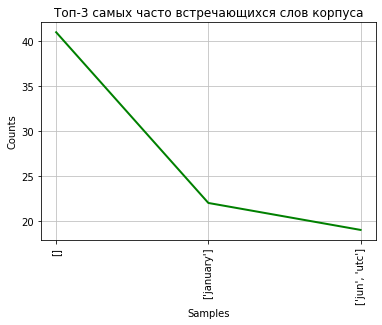

In [40]:
# выведем самые часто встречающиеся слова в корпусе

fdist = FreqDist(X)
fdist.plot(3,
           title='Топ-3 самых часто встречающихся слов корпуса',
           color='green'
          )
plt.show()

In [41]:
# выделим индексы токсичных текстов

toxic = data.loc[data['toxic']==1].index

In [42]:
# выделим токсичные тексты в отдельный список

toxic_text = X[list(toxic)]

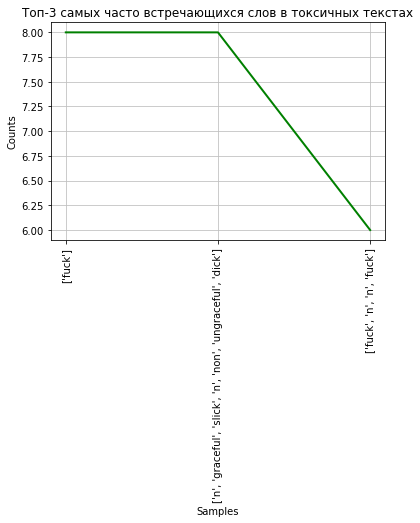

In [44]:
# выведем самые часто встречающиеся слова токсичных текстов

fdist = FreqDist(toxic_text)
fdist.plot(3,
           title='Топ-3 самых часто встречающихся слов в токсичных текстах',
           color='green'
          )
plt.show()

Text(0.5, 1.0, 'Облако слов всех текстов')

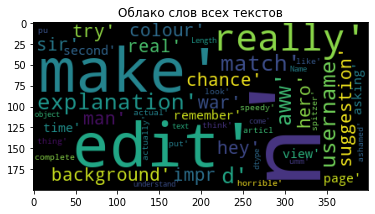

In [47]:
# выведем облако слов всего корпуса

cloud = WordCloud(collocations=False).generate(str(X))

plt.imshow(cloud)
plt.title('Облако слов всех текстов')

Text(0.5, 1.0, 'Облако слов токсичных текстов')

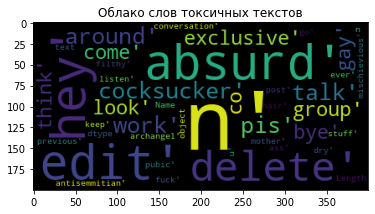

In [48]:
# выведем облако слов токсичных текстов

toxic_cloud = WordCloud(collocations=False).generate(str(toxic_text))

plt.imshow(toxic_cloud)
plt.title('Облако слов токсичных текстов')

## Подготовка к обучению 

In [49]:
# выделим целевой признак

y = data['toxic']

In [50]:
# разделим данные на обучающую и тестовую выборки, при этом сохраним дисбаланс классов при разделении выборок 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [51]:
# проверим размерность

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(111504,)
(111504,)
(47788,)
(47788,)


In [52]:
# зададим параметры сетки логистической регрессии

lr_params = {'lr__solver': ['newton-cg','sag', 'lbfgs', 'liblinear'],
             'lr__class_weight': ['balanced'],
             'lr__max_iter' : [100, 1000]
              }

In [53]:
# зададим параметры сетки дерева

tree_params = {'tree__max_depth': range (1,10),
              'tree__min_samples_leaf': range (2,4,2),
              'tree__min_samples_split': range (2,4,2)
              }

In [68]:
# зададим параметры сетки леса

forest_params = {'forest__n_estimators': range (5, 25, 5),
                 'forest__max_depth': range (1,5),
                 'forest__min_samples_leaf': range(2,4,2),
                 'forest__min_samples_split': range(2,4,2)
                }

# Обучение с помощью мешка слов

Попробуем обучить модель с помощью мешка слов, подобрав оптимальные параметры с помощью GridSearch


In [69]:
# создадим пайплайн логистической регрессии 

lr_bag_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('lr', LogisticRegression(random_state = 42))
])

In [70]:
%%time

# применим GridSearchCV и выведем лучшие гиперпараметры

grid_lr_bag = GridSearchCV(lr_bag_pipe, lr_params, cv=3, scoring='f1')
grid_lr_bag.fit(X_train, y_train)
print('best params', grid_lr_bag.best_params_)
print('f1', grid_lr_bag.best_score_)

C:\Users\OLGAIARO\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\OLGAIARO\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\OLGAIARO\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\OLGAIARO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

best params {'lr__class_weight': 'balanced', 'lr__max_iter': 1000, 'lr__solver': 'liblinear'}
f1 0.7600071413496411
CPU times: total: 10min 49s
Wall time: 14min 53s


C:\Users\OLGAIARO\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [71]:
# создадим пайплайн дерева решений 

tree_bag_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tree', DecisionTreeClassifier(random_state = 42))
])

In [72]:
%%time

# применим GridSearchCV и выведем лучшие гиперпараметры

grid_tree_bag = GridSearchCV(tree_bag_pipe, tree_params, cv=3, scoring='f1')
grid_tree_bag.fit(X_train, y_train)
print('best params', grid_tree_bag.best_params_)
print('f1', grid_tree_bag.best_score_)

best params {'tree__max_depth': 9, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 2}
f1 0.5901391914204381
CPU times: total: 1min 23s
Wall time: 2min 33s


In [73]:
# создадим пайплайн случайного леса 

forest_bag_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('forest', RandomForestClassifier(random_state = 42))
])

In [74]:
%%time

# применим GridSearchCV и выведем лучшие параметры

grid_forest_bag = GridSearchCV(forest_bag_pipe, forest_params, cv=3, scoring='f1')
grid_forest_bag.fit(X_train, y_train)
print('best params', grid_forest_bag.best_params_)
print('f1', grid_forest_bag.best_score_)

best params {'forest__max_depth': 1, 'forest__min_samples_leaf': 2, 'forest__min_samples_split': 2, 'forest__n_estimators': 5}
f1 0.0
CPU times: total: 2min 7s
Wall time: 3min 53s


<div class="alert alert-warning">

**Вывод**

При обучении с помощью мешка слов лучшую метрику качества показала Логистическая регрессия - 0.76.

F1 Дерева решений составило 0.59, а Случайного леса - 0

# Обучение с помощью TF-IDF

In [75]:
# создадим пайплайн логистической регрессии 

lr_tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state = 42))
])

In [76]:
%%time

# применим GridSearchCV и выведем лучшие гиперпараметры

grid_lr_tfidf = GridSearchCV(lr_tfidf_pipe, lr_params, cv=3, scoring='f1')
grid_lr_tfidf.fit(X_train, y_train)
print('best params', grid_lr_tfidf.best_params_)
print('f1', grid_lr_tfidf.best_score_)

C:\Users\OLGAIARO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


best params {'lr__class_weight': 'balanced', 'lr__max_iter': 100, 'lr__solver': 'lbfgs'}
f1 0.747682604656327
CPU times: total: 1min 54s
Wall time: 3min 3s


In [77]:
# создадим пайплайн дерева решений 

tree_tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('tree', DecisionTreeClassifier(random_state = 42))
])

In [78]:
%%time

# применим GridSearchCV и выведем лучшие гиперпараметры

grid_tree_tfidf = GridSearchCV(tree_tfidf_pipe, tree_params, cv=3, scoring='f1')
grid_tree_tfidf.fit(X_train, y_train)
print('best params', grid_tree_tfidf.best_params_)
print('f1', grid_tree_tfidf.best_score_)

best params {'tree__max_depth': 9, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 2}
f1 0.5858384897794926
CPU times: total: 1min 27s
Wall time: 3min 13s


In [79]:
# создадим пайплайн случайного леса 

forest_tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('forest', RandomForestClassifier(random_state = 42))
])

In [80]:
%%time

# применим GridSearchCV и выведем лучшие параметры

grid_forest_tfidf = GridSearchCV(forest_tfidf_pipe, forest_params, cv=3, scoring='f1')
grid_forest_tfidf.fit(X_train, y_train)
print('best params', grid_forest_tfidf.best_params_)
print('f1', grid_forest_tfidf.best_score_)

best params {'forest__max_depth': 1, 'forest__min_samples_leaf': 2, 'forest__min_samples_split': 2, 'forest__n_estimators': 5}
f1 0.0
CPU times: total: 2min 12s
Wall time: 3min 51s


<div class="alert alert-warning">

**Вывод**

При обучении с помощью важности слов tf-idf качество Логистической регрессии немного упало - 0.747.
F1 Дерева решений составило 0.585, а Случайного леса - 0

# Тест

Так как самый высокий показатель качества был на логистической регрессии при использовании мешка слов - используем эту модель для теста

In [81]:
# выведем предсказания на модели с лучшим качеством на обучении

y_pred = grid_lr_bag.best_estimator_.predict(X_test)
best_f1 = f1_score(y_pred, y_test)
print('Значение F1 на тесте -', best_f1)

Значение F1 на тесте - 0.7635680751173709


# Вывод

<div class="alert alert-info">

Для предсказания тональности текста была проведена предобработка текста:
  - токенизация и лемматизация данных
  - привод всех слов к нижнему регистру
  - очистка текста от стоп-слов, лишних символов и чисел 

Для построения векторов были использованы 2 способа:
  - мешок слов CountVectorizer 
  - важность слов TF-IDF

Лучшая модель подбиралась с помощью поиска по сетке GridSearchCV. Для подбора использовались:
 - Логистическая регрессия
 - Дерево решений
 - Случайный лес
 
Самые высокие показатели метрики качества выдала Логистическая регрессия с сильным отрывом от других моделей, при этом использование мешка слов показало качество немного выше, чем tf-idf.

Метрика F1 на обучении составила 0.76, на тесте - 0.763